# "American sign language classifier from scratch"

- toc: false
- branch: master
- badges: true
- comments: true
- categories: [classifier, scratch, vision]
- hide: false
- search_exclude: true
- metadata_key1: metadata_value1
- metadata_key2: metadata_value2

In [1]:
from fastai.vision.all import *
import pandas as pd

In [2]:
df = pd.read_csv('/code/datasets/mnist_sign/sign_mnist_train.csv')
classes = [3, 1, 23, 22]
df = df[df.label.isin(classes)]
train_df = df.sample(frac=0.7, random_state=100)
test_df = df.drop(train_df.index)

train_df.shape, test_df.shape

((3216, 785), (1379, 785))

In [3]:
def get_labels(df):
    return tensor(df.iloc[:, 0].values)

def get_image_tensors(df):
    return torch.stack([tensor(image_array)/255. for image_array in df.iloc[:, 1:].values])

def get_dataset(df):
    return zip(get_image_tensors(df), get_labels(df))

In [4]:
dataset = get_dataset(df)

tensor(3)
tensor(22)


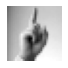

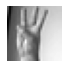

In [5]:
for image_tensor, label in list(dataset)[:2]:
    print(label)
    show_image(torch.reshape(image_tensor, (28, 28)), cmap='gray')

### Initialize weights

In [6]:
def get_random_weights(rows, cols):
    return torch.randn(rows, cols).requires_grad_()

In [7]:
weights = get_random_weights(28*28, len(classes))
bias = get_random_weights(1, len(classes))
weights.shape, bias.shape

(torch.Size([784, 4]), torch.Size([1, 4]))

### Get Predictions 

In [8]:
image_tensors = get_image_tensors(train_df)
image_tensors.shape, weights.shape

(torch.Size([3216, 784]), torch.Size([784, 4]))

In [9]:
def get_predictions(image_tensors, weights, bias):
    return image_tensors@weights + bias

In [10]:
predictions = get_predictions(image_tensors, weights, bias)
predictions.shape

torch.Size([3216, 4])

Check initial accuracy

In [11]:
test_image_tensors, test_labels = get_image_tensors(test_df), get_labels(test_df)
test_preds = get_predictions(test_image_tensors, weights, bias)
pred_classes = torch.argmax(test_preds, dim=1)

# This will select the class value based on index of pred_classes
preds = tensor(classes).gather(0, pred_classes)
(preds == test_labels).float().mean() 

# Random weights are ~26% accurate

tensor(0.2473)

In [12]:
preds

tensor([23, 23, 23,  ..., 23, 23, 23])

In [13]:
test_labels

tensor([ 3,  3,  3,  ...,  1, 22,  1])

### Calculate loss

In [29]:
labels = get_labels(train_df)
# get each label class
target_classes = tensor([classes.index(c) for c in labels])
target_classes[:5]

tensor([2, 0, 3, 0, 3])

In [15]:
# softmax function turns the predictions into probabilities and amplifies the predictions 
def softmax(predictions):
    return torch.exp(predictions)/torch.exp(predictions).sum(dim=1, keepdim=True)
# pytorch equivalent
activations_py = torch.softmax(predictions, dim=1)
activations = softmax(predictions)

activations[0], activations_py[0]

(tensor([1.0615e-09, 9.8741e-23, 1.0000e+00, 2.1552e-17],
        grad_fn=<SelectBackward>),
 tensor([1.0615e-09, 9.8741e-23, 1.0000e+00, 2.1552e-17],
        grad_fn=<SelectBackward>))

In [16]:
# mean of corresponding activations based on the target class
loss = activations[range(len(target_classes)), target_classes].mean()
# pytorch equivalent 
loss_py = -F.nll_loss(activations, target_classes)

loss, loss_py

(tensor(0.2465, grad_fn=<MeanBackward0>),
 tensor(0.2465, grad_fn=<NegBackward>))

In [17]:
# as softmax function turns predictions into probabilities, each activation is bounded between (0, 1) hence our model considers 0.900 and 0.999 as the same but the second prediction is 100 times more confident hence we use log to amplify the domain to (-inf, inf)

In [18]:
# softmax + log + negative_loss_likelyhood = cross_entropy_loss: this can be used for classification problems
def cross_entropy_loss(predictions, target_classes): 
    activations = softmax(predictions)
    activations_log = torch.log(activations)
    loss = activations_log[range(len(target_classes)), target_classes].mean()
    return -loss
# pytorch equivalent
cross_entropy_loss_py = F.cross_entropy(predictions, target_classes)

cross_entropy_loss(predictions, target_classes), cross_entropy_loss_py

(tensor(20.1099, grad_fn=<NegBackward>),
 tensor(20.1099, grad_fn=<NllLossBackward>))

### Optimise weights

In [19]:
def train_epoch(dl, weights, bias, learning_rate):
    for x, y in dl:
        preds = get_predictions(x, weights, bias)
        loss = cross_entropy_loss(preds, tensor([classes.index(item) for item in y]))
        loss.backward()
        weights.data = weights.data - weights.grad*learning_rate
        bias.data -= bias.grad*learning_rate
        weights.grad.zero_()
        bias.grad.zero_()
    print(f'loss={loss}')
    return weights, bias

In [39]:
for i in range(50):
    dl = DataLoader(get_dataset(train_df), batch_size=256)
    weights, bias = train_epoch(dl, weights, bias, 1e-1)

loss=0.03809681162238121
loss=0.03796125203371048
loss=0.0378265306353569
loss=0.03769278526306152
loss=0.037559859454631805
loss=0.03742798790335655
loss=0.03729705139994621
loss=0.037166863679885864
loss=0.03703761100769043
loss=0.036909230053424835
loss=0.03678176552057266
loss=0.036655157804489136
loss=0.03652939945459366
loss=0.03640443831682205
loss=0.03628034517168999
loss=0.03615706413984299
loss=0.03603459149599075
loss=0.035912953317165375
loss=0.03579215705394745
loss=0.0356721431016922
loss=0.03555278852581978
loss=0.035434331744909286
loss=0.03531665354967117
loss=0.03519975394010544
loss=0.03508364409208298
loss=0.03496823087334633
loss=0.0348534919321537
loss=0.03473963215947151
loss=0.03462645784020424
loss=0.03451396897435188
loss=0.03440222889184952
loss=0.03429122269153595
loss=0.034180786460638046
loss=0.034071292728185654
loss=0.033962275832891464
loss=0.033854126930236816
loss=0.03374640643596649
loss=0.03363959118723869
loss=0.033533405512571335
loss=0.0334278978

In [40]:
test_image_tensors, test_labels = get_image_tensors(test_df), get_labels(test_df)
test_preds = get_predictions(test_image_tensors, weights, bias)
pred_classes = torch.argmax(test_preds, dim=1)

# This will select the class value based on index of pred_classes
preds = tensor(classes).gather(0, pred_classes)
(preds == test_labels).float().mean() 

# Random weights are ~26% accurate

tensor(0.9978)

In [22]:
preds

tensor([ 3,  3,  3,  ...,  1, 22,  1])

In [23]:
test_labels

tensor([ 3,  3,  3,  ...,  1, 22,  1])

In [24]:
bias

tensor([[ 0.5173,  1.2840, -1.5024,  0.7560]], requires_grad=True)

<AxesSubplot:>

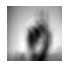

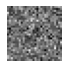

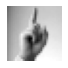

In [66]:
show_image(
    torch.reshape(
        tensor(df[df.label == classes[0]].values).float().mean(0)[1:],
        (28, 28)
    ),
    cmap='gray'
)
show_image(
    torch.reshape(weights[:, 0], (28, 28)),
    cmap='gray'
)
show_image(
    torch.reshape(
        tensor(df[df.label == classes[0]].values[0][1:]),
        (28, 28)
    ),
    cmap='gray'
)

<AxesSubplot:>

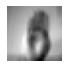

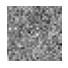

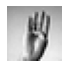

In [65]:
show_image(
    torch.reshape(
        tensor(df[df.label == classes[1]].values).float().mean(0)[1:],
        (28, 28)
    ),
    cmap='gray'
)
show_image(
    torch.reshape(weights[:, 1], (28, 28)),
    cmap='gray'
)
show_image(
    torch.reshape(
        tensor(df[df.label == classes[1]].values[0][1:]),
        (28, 28)
    ),
    cmap='gray'
)

<AxesSubplot:>

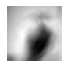

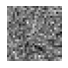

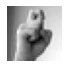

In [67]:
show_image(
    torch.reshape(
        tensor(df[df.label == classes[2]].values).float().mean(0)[1:],
        (28, 28)
    ),
    cmap='gray'
)
show_image(
    torch.reshape(weights[:, 2], (28, 28)),
    cmap='gray'
)
show_image(
    torch.reshape(
        tensor(df[df.label == classes[2]].values[0][1:]),
        (28, 28)
    ),
    cmap='gray'
)

<AxesSubplot:>

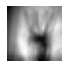

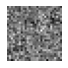

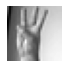

In [64]:
show_image(
    torch.reshape(
        tensor(df[df.label == classes[3]].values).float().mean(0)[1:],
        (28, 28)
    ),
    cmap='gray'
)
show_image(
    torch.reshape(weights[:, 3], (28, 28)),
    cmap='gray'
)
show_image(
    torch.reshape(
        tensor(df[df.label == classes[3]].values[0][1:]),
        (28, 28)
    ),
    cmap='gray'
)

In [69]:
get_predictions(tensor(df[df.label == classes[3]].values).float().mean(0)[1:], weights, bias)

tensor([[ 328.1530, -383.5043,  399.9599, 1811.2157]], grad_fn=<AddBackward0>)

In [70]:
get_predictions(tensor(df[df.label == classes[2]].values).float().mean(0)[1:], weights, bias)

tensor([[  127.9882, -1535.2252,  2507.4573,  -280.5247]],
       grad_fn=<AddBackward0>)

In [71]:
get_predictions(tensor(df[df.label == classes[1]].values).float().mean(0)[1:], weights, bias)

tensor([[ 352.4848, 1673.3523, -312.3260, -237.1402]], grad_fn=<AddBackward0>)

In [72]:
get_predictions(tensor(df[df.label == classes[0]].values).float().mean(0)[1:], weights, bias)

tensor([[1945.2909, -507.1653,  186.0164, -497.4277]], grad_fn=<AddBackward0>)